In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import imageio
import os
from tqdm import tqdm
import gc
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


2023-11-02 13:30:23.908515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 13:30:24.034710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 13:30:24.034753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 13:30:24.034804: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 13:30:24.059468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 13:30:24.060203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:

brain_cancer_path = 'mcc'


In [3]:
directories = []
for directory in os.listdir(brain_cancer_path):
    directories.append(directory)
print('Classes Present : ',list(directories))


Classes Present :  ['all_pre', 'all_early', 'oral_scc', 'all_benign', 'oral_normal', 'all_pro']


In [4]:
all_pre_files=[]
all_early_files = []
oral_scc_files = []
all_benign_files = []
oral_normal_files = []
all_pro_files = []
for directory in directories:
    for files in os.listdir(os.path.join(brain_cancer_path,directory)):
        if directory == 'all_pre':
            all_pre_files.append(os.path.join(brain_cancer_path,'all_pre',files))
        elif directory == 'all_early':
            all_early_files.append(os.path.join(brain_cancer_path,'all_early',files))
        elif directory == 'oral_scc':
            oral_scc_files.append(os.path.join(brain_cancer_path,'oral_scc',files))
        elif directory == 'all_benign':
            all_benign_files.append(os.path.join(brain_cancer_path,'all_benign',files))
        elif directory == 'oral_normal':
            oral_normal_files.append(os.path.join(brain_cancer_path,'oral_normal',files))
        elif directory == 'all_pro':
            all_pro_files.append(os.path.join(brain_cancer_path,'all_pro',files))


In [5]:
print('Total all_pre_files : ',len(all_pre_files))
print('Total all_early_files : ',len(all_early_files))
print('Total oral_scc_files : ',len(oral_scc_files))
print('Total all_benign_files : ',len(all_benign_files))
print('Total oral_normal_files : ',len(oral_normal_files))
print('Total all_pro_files : ',len(all_pro_files))


Total all_pre_files :  5000
Total all_early_files :  5000
Total oral_scc_files :  5001
Total all_benign_files :  5000
Total oral_normal_files :  5001
Total all_pro_files :  5000


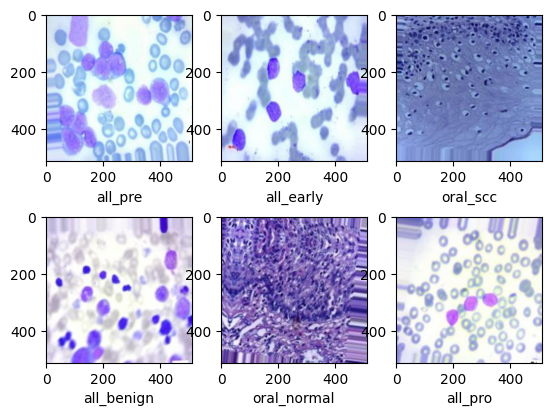

In [6]:

random_num = random.randint(0,len(all_pre_files))
brain_tumor_pic = all_pre_files[random_num]
brain_early_pic = all_early_files[random_num]
oral_scc_pic = oral_scc_files[random_num]
brain_benign_pic = all_benign_files[random_num]
oral_normal_pic = oral_normal_files[random_num]
brain_pro_pic = all_pro_files[random_num]
brain_tumor_data = imageio.imread(brain_tumor_pic)
brain_early_data = imageio.imread(brain_early_pic)
oral_scc_data = imageio.imread(oral_scc_pic)
brain_benign_data = imageio.imread(brain_benign_pic)
oral_normal_data = imageio.imread(oral_normal_pic)
brain_pro_data = imageio.imread(brain_pro_pic)
fig,axs = plt.subplots(2,3)
axs[0,0].imshow(brain_tumor_data)
axs[0,1].imshow(brain_early_data)
axs[0,2].imshow(oral_scc_data)
axs[1,0].imshow(brain_benign_data)
axs[1,1].imshow(oral_normal_data)
axs[1,2].imshow(brain_pro_data)
axs[0,0].set_xlabel('all_pre')
axs[0,1].set_xlabel('all_early')
axs[0,2].set_xlabel('oral_scc')
axs[1,0].set_xlabel('all_benign')
axs[1,1].set_xlabel('oral_normal')
axs[1,2].set_xlabel('all_pro')
plt.show()

In [7]:

gc.collect()


0

In [8]:

generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)


In [9]:
train_ds = generator.flow_from_directory(
    'mcc',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_ds = generator.flow_from_directory(
    'mcc',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 24002 images belonging to 6 classes.
Found 6000 images belonging to 6 classes.


In [10]:

checkpoint_filepath = 'checkpoints'
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
]


In [11]:
from torchvision.models import ResNet50_Weights, resnet50

In [12]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model_resnet.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
history = model.fit(train_ds,verbose = 1,epochs = 10,batch_size = 32,validation_data = val_ds,callbacks = callback)

Epoch 1/10


2023-11-02 13:30:48.883471: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-11-02 13:30:48.953190: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-11-02 13:30:48.992620: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.
2023-11-02 13:30:49.036330: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-11-02 13:30:49.077769: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


235/751 [========>.....................] - ETA: 15:08 - loss: 0.3010 - accuracy: 0.8844

KeyboardInterrupt: 

In [ ]:
model.save('mcc.h5')